In [1]:
import os, sys, platform

# Variables

In [2]:
## Seed for the random variables
SEED_NUMBER=1;

## Kfold 
K=2;                    # Variable K of kfold
FOLD_STATUS_FILE='fold_status.json';

## Training hyperparameters
EPOCHS=400;
BATCH_SIZE=128;

## Model of network
#MODEL_TYPE  = 'model_sector4';
#MODEL_TYPE  = 'model_sectortree';
MODEL_TYPE  = 'model_sectortree2';
#MODEL_TYPE = 'model_max'

DATASET_NAME = 'mcfer2023';
#DATASET_NAME = 'ck+48';

CPU_NAME = 'cpulab';

OUTPUT_BASE_DIR='output';

# Bibliotecas externas

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime

2023-07-03 13:38:45.489135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 13:39:50.998085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fernando/anaconda3/lib/
2023-07-03 13:39:50.998401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fernando/anaconda3/lib/
2023-07-03 13:39:50.998407: W tensorflow/compiler/tf2tensorrt/utils/

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2023-07-03 13:40:04.525495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 13:40:05.706993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 13:40:05.707093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Biblioteca local


In [5]:
sys.path.append('library');
sys.path.append('../src');

import tools_dataset as toolsd
import tools_model   as toolsm

# If command line

In [6]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--model':
        MODEL_TYPE=sys.argv[n+1];
    if sys.argv[n]=='--epochs':
        EPOCHS=int(sys.argv[n+1]);
    if sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    if sys.argv[n]=='--dataset':
        DATASET_NAME=sys.argv[n+1];
    if sys.argv[n]=='--cpu':
        CPU_NAME=sys.argv[n+1];
    if sys.argv[n]=='--output-base-dir':
        OUTPUT_BASE_DIR=sys.argv[n+1];
        
print('     MODEL_TYPE:',MODEL_TYPE)
print('         EPOCHS:',EPOCHS)
print('     BATCH_SIZE:',BATCH_SIZE)
print('   DATASET_NAME:',DATASET_NAME)
print('       CPU_NAME:',CPU_NAME)
print('OUTPUT_BASE_DIR:',OUTPUT_BASE_DIR)

     MODEL_TYPE: model_sectortree2
         EPOCHS: 400
     BATCH_SIZE: 128
   DATASET_NAME: mcfer2023
       CPU_NAME: cpulab
OUTPUT_BASE_DIR: output


# Load data

In [7]:
dataset_csv_train_file, dataset_csv_test_file, dataset_train_base_dir, input_shape, nout = toolsd.load_dataset(dataset_name=DATASET_NAME,
                                                                                                               cpu_name=CPU_NAME);

print('dataset_csv_train_file:',dataset_csv_train_file)
print(' dataset_csv_test_file:',dataset_csv_test_file)

OUTPUT_BASE_DIR=os.path.join(OUTPUT_BASE_DIR,DATASET_NAME);


dataset_csv_train_file: /media/fernando/B0EA304AEA300EDA/Dados/Fernando/DATASET/mcfer_v1.0/archive/train/training_labels.csv
 dataset_csv_test_file: /media/fernando/B0EA304AEA300EDA/Dados/Fernando/DATASET/mcfer_v1.0/archive/test/test_labels.csv


# Set seed of random variables


In [8]:
np.random.seed(SEED_NUMBER)
tf.keras.utils.set_random_seed(int(SEED_NUMBER));

# Setting the cross-validation kfold


In [9]:
from sklearn.model_selection import KFold, StratifiedKFold

# output directory
output_dir = os.path.join(OUTPUT_BASE_DIR,'skfold'+str(K)+'_'+MODEL_TYPE);

# K-fold object
kf = StratifiedKFold(n_splits = K, shuffle = True, random_state = SEED_NUMBER);

# fold status file
fold_status_path=os.path.join(output_dir,FOLD_STATUS_FILE);

print('      output_dir:',output_dir)
print('fold_status_path:',fold_status_path)

      output_dir: output/mcfer2023/skfold2_model_sectortree2
fold_status_path: output/mcfer2023/skfold2_model_sectortree2/fold_status.json


# Loading data of dataset

In [10]:
# Load filenames and labels
train_data = pd.read_csv(dataset_csv_train_file);
print(train_data)

# Setting labels
Y   = train_data[['label']];

L=np.shape(Y)[0];

                                    filename      label
0           angry/angry-contempt/im344_2.png      angry
1      disgusted/awful/affectnet_0036766.png  disgusted
2       fearful/attention-fearful/im32_1.png    fearful
3         happy/attention-happy/im1325_2.png      happy
4                neutral/attention/im2_1.png    neutral
...                                      ...        ...
24215           happy/light-smile/im4742.png      happy
24216           happy/light-smile/im4809.png      happy
24217         happy/light-smile/im4921_1.png      happy
24218           happy/light-smile/im5535.png      happy
24219           happy/light-smile/im5545.png      happy

[24220 rows x 2 columns]


# Data augmentation configuration

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg    = ImageDataGenerator(rescale=1./255,
                            rotation_range = 10,
                            width_shift_range= 0.07,
                            height_shift_range= 0.07,
                            horizontal_flip=True,
                            shear_range=1.25,
                            zoom_range = [float(0.9), float(1.1)] 
                            )

idg_val= ImageDataGenerator(rescale=1./255 )



# Auxiliar function

In [12]:
def get_model_name(k,rep=None):
    if rep==None:
        return 'model_'+str(k)+'.h5'
    else:
        return 'model_'+str(k)+'_'+rep+'.h5'

# Creating output directory

In [13]:

try: 
    os.makedirs(output_dir) 
except: 
    pass


# Cross-validation


Fold 1 of 2
length train: 12110 elements
length val  : 12110 elements


2023-07-03 13:40:14.706365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 13:40:14.724344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 13:40:14.724457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 13:40:14.724533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Loaded model_sectortree2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      7808      
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 4)       10372     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 4)      0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 32)      6304      
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 4)       6276      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 4)      16        
 ormalization)               

2023-07-03 13:40:58.425367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-03 13:41:19.609586: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-03 13:41:40.792062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-03 13:41:41.512248: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe58c037320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 13:41:41.512262: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-07-03 13:41:42.282680: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 13:41:47.10128

95/95 [==============================] - ETA: 0s - loss: 0.7816 - categorical_accuracy: 0.7115
Epoch 1: val_categorical_accuracy improved from -inf to 0.63865, saving model to output/mcfer2023/skfold2_model_sectortree2/model_1.h5
95/95 [==============================] - 182s 922ms/step - loss: 0.7816 - categorical_accuracy: 0.7115 - val_loss: 1.0212 - val_categorical_accuracy: 0.6386
Epoch 2/400
95/95 [==============================] - ETA: 0s - loss: 0.7795 - categorical_accuracy: 0.7073
Epoch 2: val_categorical_accuracy improved from 0.63865 to 0.65062, saving model to output/mcfer2023/skfold2_model_sectortree2/model_1.h5
95/95 [==============================] - 80s 837ms/step - loss: 0.7795 - categorical_accuracy: 0.7073 - val_loss: 0.9959 - val_categorical_accuracy: 0.6506
Epoch 3/400
95/95 [==============================] - ETA: 0s - loss: 0.7635 - categorical_accuracy: 0.7164
Epoch 3: val_categorical_accuracy did not improve from 0.65062
95/95 [==============================] - 7

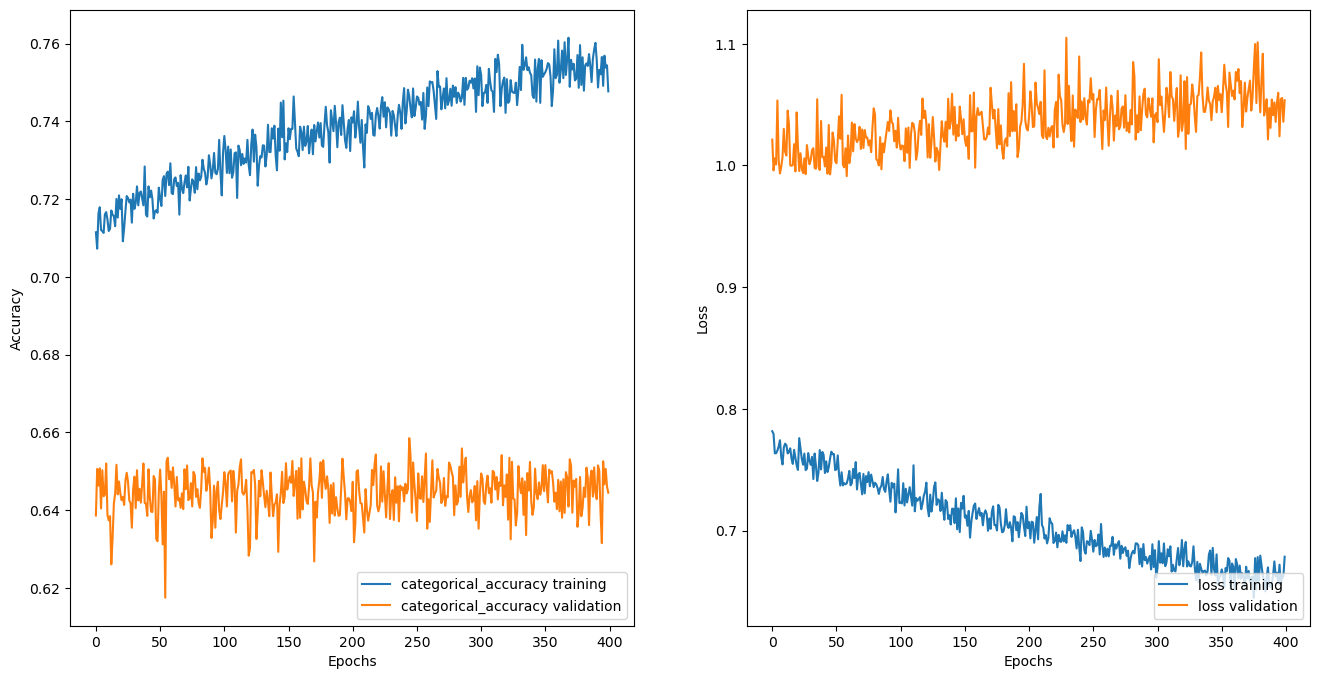

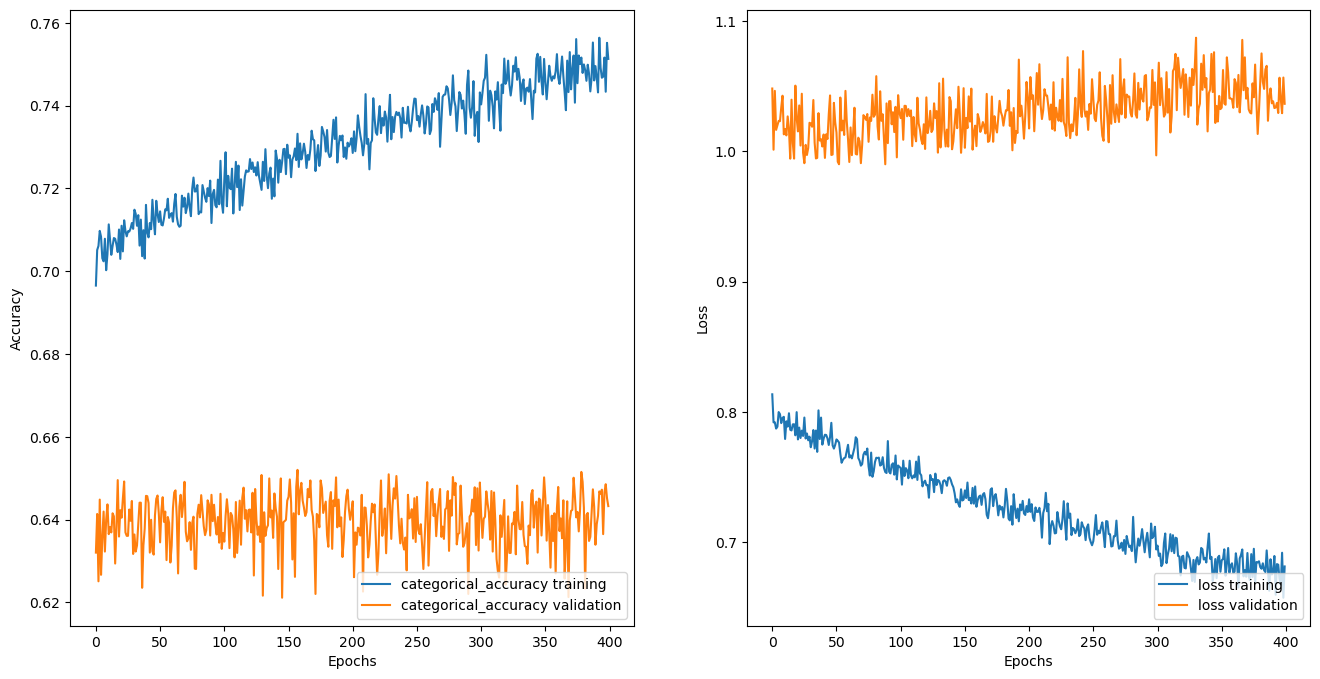

In [14]:
import tools_model as mpp
import matplotlib.pyplot as plt


list_train_index=[];
list_val_index=[];
for train_index, val_index in kf.split(np.zeros(L),Y):
    list_train_index.append(train_index);
    list_val_index.append(val_index);

import json
data_fold =  {'VALIDATION_ACCURACY': [],'VALIDATION_LOSS': [] };

fold_var=1;

if os.path.isfile(fold_status_path):
    # Read JSON file
    with open(fold_status_path) as data_file:
        data_fold = json.load(data_file)
        fold_var=len(data_fold['VALIDATION_ACCURACY'])+1;
    
while fold_var<=K:
    training_data   = train_data.iloc[list_train_index[fold_var-1]]
    validation_data = train_data.iloc[list_val_index[fold_var-1]]

    print('\nFold',fold_var,'of',K);
    print('length train:',len(list_train_index[fold_var-1]),'elements');
    print('length val  :',len(list_val_index[fold_var-1]),'elements');

    # CREATE NEW MODEL
    
    model, target_size = mpp.create_model(  file_of_weight='',
                                            model_type=MODEL_TYPE,
                                            input_shape=input_shape,
                                            nout=nout)
    
    model.summary()
    
    try:
        print('***** Loding the best old model file ... *****')
        model.load_weights(os.path.join(output_dir,get_model_name(fold_var,rep='r1')));
    except: 
        pass;
    train_data_generator = idg.flow_from_dataframe(training_data, 
                                                   directory = dataset_train_base_dir,
                                                   target_size=target_size,
                                                   x_col = "filename", 
                                                   y_col = "label",
                                                   batch_size=BATCH_SIZE,
                                                   class_mode="categorical",
                                                   shuffle = True);
    
    valid_data_generator  = idg_val.flow_from_dataframe(validation_data, 
                                                    directory = dataset_train_base_dir,
                                                    target_size=target_size,
                                                    x_col = "filename", 
                                                    y_col = "label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle = True)
    
    #STEPS_BY_EPOCHS=len(train_data_generator);
    

    
    # COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    # CREATE CALLBACKS
    best_model_file=os.path.join(output_dir,get_model_name(fold_var));
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                    save_weights_only=True,
                                                    monitor='val_categorical_accuracy', 
                                                    save_best_only=True, 
                                                    verbose=1);
    
    log_dir = os.path.join(output_dir,"logs","fit" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                        #steps_per_epoch=STEPS_BY_EPOCHS,
                        epochs=EPOCHS,
                        validation_data=valid_data_generator,
                        callbacks=[checkpoint,tensorboard_callback],
                        verbose=1
                       );
    print('***** Saving the history *****')

    #PLOT HISTORY
    mpp.save_model_history(history,os.path.join(output_dir,"historical_"+str(fold_var)+".csv"), labels=['categorical_accuracy','loss'],show=False);
    
    print('***** Loding the best model file ... *****')
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(best_model_file);
    
    print('***** Evaluating the model ... *****')
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    print(results,"\n\n");
    
    data_fold['VALIDATION_ACCURACY'].append(results['categorical_accuracy'])
    data_fold['VALIDATION_LOSS'].append(results['loss'])
    
    # Data fold
    with open(fold_status_path, 'w') as f:
        json.dump(data_fold, f);

    tf.keras.backend.clear_session()
    
    fold_var += 1

In [15]:
fpath=os.path.join(output_dir,"final_stats.csv");
mean_val_acc=mpp.save_model_stat_kfold(data_fold, fpath);

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.txt'));

print(mean_val_acc)

{'VALIDATION_ACCURACY_MEAN': 0.6552848815917969, 'VALIDATION_LOSS_MEAN': 1.0270551443099976}
